# Dev Notebook Solution

## Data 

In [123]:
# numpy and pandas for data manipulation
import pandas as pd
import numpy as np
from scipy.stats import skew

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno
from pandas_profiling import ProfileReport
from plot_metric.functions import BinaryClassification

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

#Setting Options for Better Display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
from IPython.core.display import display, HTML


In [167]:
## Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline 

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

#Common Model Helpers
from sklearn import feature_selection
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import log_loss

# the libraries we need
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, make_scorer

<b> Load Raw Data </b>

In [131]:
data = pd.read_csv('bank-additional raw/bank-additional-full.csv',low_memory=False,delimiter=';')
print(data.shape)

(41188, 21)


In [132]:
data['id'] = list(range(1,41189))

In [133]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,id
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,3
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,4
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5


### Seperating Data to Train and Test with random sample, keeping ratio of 80/20
- I am splitting 20% of the data for final testing.
- This helps us ensure that we are building ML framework without any bias as we don't see the test data in industry applications

In [43]:
train = data.sample(n=32950) 
test = data[~data['id'].isin(train['id'])]
print(f"Train Shape ",train.shape)
print(f"Test Shape ",test.shape)

train.to_csv('datasets/ML_Train.csv',index=False)
test.to_csv('datasets/ML_Test.csv',index=False)

Train Shape  (32950, 22)
Test Shape  (8238, 22)


In [3]:
train = pd.read_csv('datasets/ML_Train.csv',low_memory=False)
test = pd.read_csv('datasets/ML_Test.csv',low_memory=False)

## Data Understanding

The data has 32950 records with 22 features. Ignoring the <b> id column </b> 

Also based on Description by the researchers , we should be removing the `duration` column which is identified as Target leakage attribute for this use case.

- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Reference: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

In [4]:
train.drop(columns=['duration','id'],inplace=True)

In [5]:
print(train.shape)
train.head()

(32950, 20)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,41,technician,married,basic.9y,no,no,no,telephone,may,wed,1,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,no
1,51,services,single,high.school,unknown,yes,no,telephone,may,thu,4,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
2,63,retired,married,unknown,no,yes,no,telephone,apr,wed,1,999,0,nonexistent,-1.8,93.075,-47.1,1.445,5099.1,yes
3,42,blue-collar,married,basic.9y,unknown,yes,no,cellular,may,tue,6,999,0,nonexistent,-1.8,92.893,-46.2,1.291,5099.1,no
4,42,technician,married,university.degree,no,no,no,cellular,jul,wed,3,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 20 columns):
age               32950 non-null int64
job               32950 non-null object
marital           32950 non-null object
education         32950 non-null object
default           32950 non-null object
housing           32950 non-null object
loan              32950 non-null object
contact           32950 non-null object
month             32950 non-null object
day_of_week       32950 non-null object
campaign          32950 non-null int64
pdays             32950 non-null int64
previous          32950 non-null int64
poutcome          32950 non-null object
emp.var.rate      32950 non-null float64
cons.price.idx    32950 non-null float64
cons.conf.idx     32950 non-null float64
euribor3m         32950 non-null float64
nr.employed       32950 non-null float64
y                 32950 non-null object
dtypes: float64(5), int64(4), object(11)
memory usage: 5.0+ MB


### Checking Target Distribution

#### Training
The Variable with "Yes" is around 11% which is understandable based on the use case

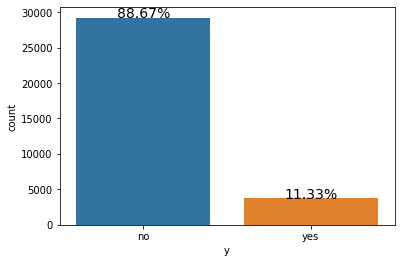

In [7]:
s = sns.countplot(x = 'y',data = train)
sizes=[]
for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train)*100),
            ha="center", fontsize=14) 

#### Test
The target proportion for test population is similar

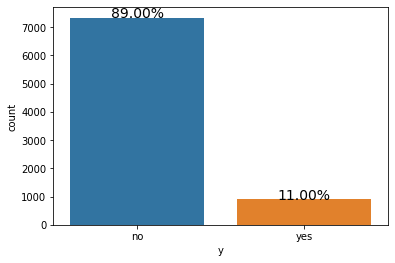

In [50]:
s = sns.countplot(x = 'y',data = test)
sizes=[]
for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(test)*100),
            ha="center", fontsize=14) 

## Exploratory Data Analysis

### Missing Data

In [125]:
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction. 
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [126]:
missing_values_table(train)

Your selected dataframe has 20 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


<AxesSubplot:>

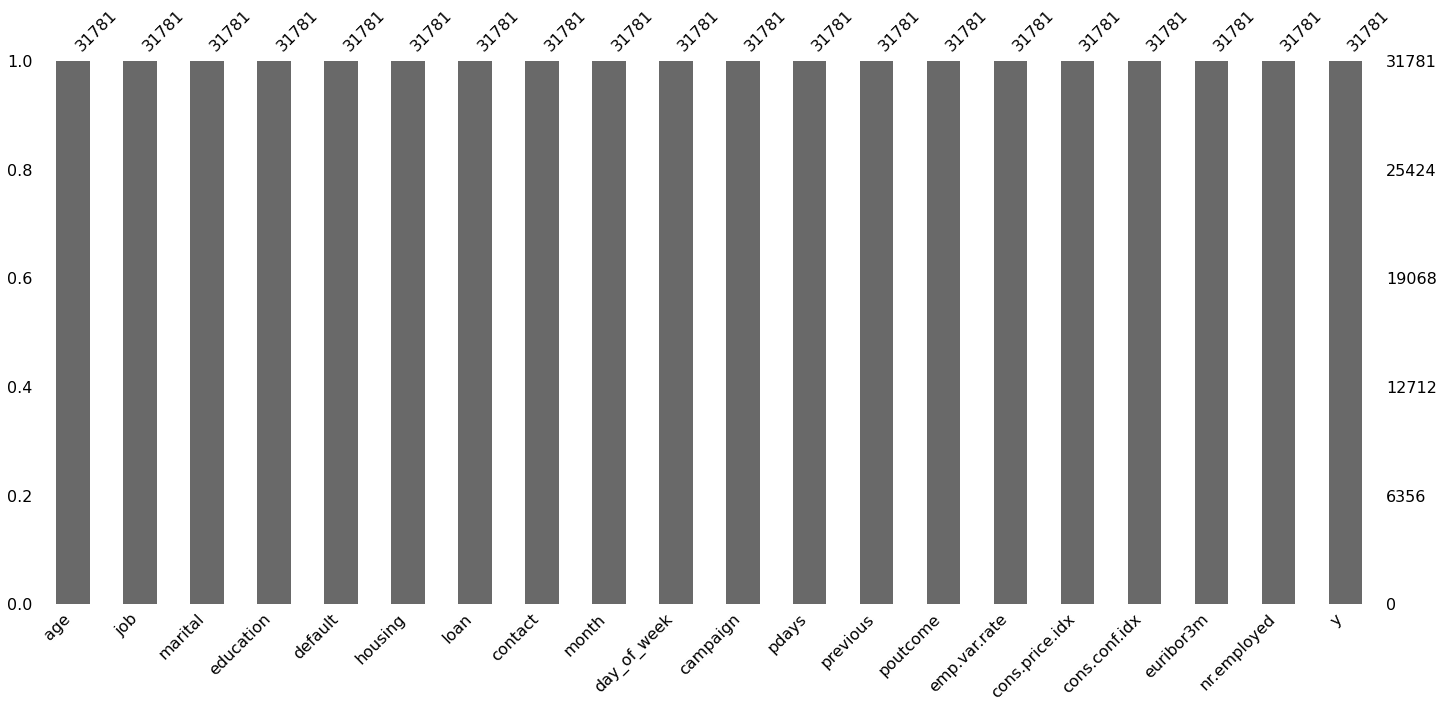

In [127]:
msno.bar(train)

Analysis:
- The data does not have any null values. 
- Reviewed the test data and it's the same case, no null columns

### Duplicates Check - Remove

In [8]:
train[train.duplicated()].shape

(1169, 20)

In [9]:
train.drop_duplicates(inplace=True)
print(train.shape)

(31781, 20)


### Outlier Analysis

In [12]:
def out_iqr(df , column):
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

<b>Printing Outliers for Numerical Columns </b>

In [22]:
for i in ['age','campaign', 'pdays','previous','emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed']:
    print("Attribute: ",i)
    print(out_iqr(train,i))
    print()

Attribute:  age
The IQR is 15.0
The lower bound value is 9.5
The upper bound value is 69.5
Total number of outliers are 360
None

Attribute:  campaign
The IQR is 2.0
The lower bound value is -2.0
The upper bound value is 6.0
Total number of outliers are 1923
None

Attribute:  pdays
The IQR is 0.0
The lower bound value is 999.0
The upper bound value is 999.0
Total number of outliers are 1207
None

Attribute:  previous
The IQR is 0.0
The lower bound value is 0.0
The upper bound value is 0.0
Total number of outliers are 4513
None

Attribute:  emp.var.rate
The IQR is 3.2
The lower bound value is -6.6000000000000005
The upper bound value is 6.200000000000001
Total number of outliers are 0
None

Attribute:  cons.price.idx
The IQR is 0.9189999999999969
The lower bound value is 91.69650000000001
The upper bound value is 95.3725
Total number of outliers are 0
None

Attribute:  cons.conf.idx
The IQR is 6.300000000000004
The lower bound value is -52.150000000000006
The upper bound value is -26.94

- We will be reviewing the univariate analysis for each attribute. 
- Based on the distribution, skewness we will be applying transformation to treat the outliers

### Univariate Analysis 

In [10]:
train.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,41,technician,married,basic.9y,no,no,no,telephone,may,wed,1,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,no
1,51,services,single,high.school,unknown,yes,no,telephone,may,thu,4,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no


<b>Using Pandas Profiling Package for Explortory Data Analysis </b>

In [120]:
profile = ProfileReport(train, title="Training Data Profiling Report", explorative=True)
profile.to_file("Univariate_Analysis.html")

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Please review the `"Univariate_Analysis.html"` in the same directory

#### Analysis

- `Age`: It seems sightly skewed. There are a few outliers based on the data. 
- `campaign`: The attribute is also skewed. We will be applying Log Tranformation to reduce skewness.
- `pdays`: It has 999 filled for unknown. We will be converting this attribute to a categorical attribute
- `euribor3m` and `nr.employed`: They are highly correlated
- `'contact','job','marital','education','default','housing','loan','contact','month','day_of_week','pdays','poutcome'` Some of the categorical attributes are highly correlated. Example `housing` and `loan`



## Feature Engineering

1. For categorical variables we would be applying
 - Label Encoder for attributes: Contact, y
 - One Hot Encoding for attributes: job,marital, education, default, housing, loan, month, day_of_week

2. For Numerical Attributes we would be transforming certain attributes

In [23]:
train2 = train.copy(deep=True)

### Numerical Attribute Transformation

#### Log Tranformation

In [ ]:
def Log_Transform(x):
    return np.log(x)

In [155]:
train2['campaign'] = train2['campaign'].apply(lambda x : Log_Transform(x))

#### Modifying `pdays` attribute based on qcut from Pandas to Convert Numerical Attribute to Categorical using binning

In [29]:
def feature_pdays(val):
    
    if 0 <= val < 5:
        return 'pdays_0_5'
    elif 5 <= val < 10:
        return 'pdays_5_10'
    elif 10 <= val < 16:
        return 'pdays_10_16'
    elif 16 <= val < 21:
        return 'pdays_16_21'
    elif 21 <= val < 21:
        return 'pdays_21_27'
    elif val >=27:
        return 'pdays_no_contact'
    else:
        return 'pdays_missing'
    
    

In [30]:
train2['pdays'] = train2['pdays'].apply(lambda x : feature_pdays(x))

In [31]:
train2['pdays'].values

array(['pdays_no_contact', 'pdays_no_contact', 'pdays_no_contact', ...,
       'pdays_no_contact', 'pdays_no_contact', 'pdays_no_contact'],
      dtype=object)

### Label Encoding

In [33]:
label = LabelEncoder()

In [34]:
train2['contact'] = label.fit_transform(train2['contact'])
train2['y'] = train2['y'].replace('no',0,regex=True)
train2['y'] = train2['y'].replace('yes',1,regex=True)

In [35]:
train2['y'].value_counts()

0    28077
1    3704 
Name: y, dtype: int64

In [36]:
train2['contact'].value_counts()

0    19961
1    11820
Name: contact, dtype: int64

### OneHot Encoding

In [37]:
def OneHotEnc(df,column):
    ohc = OneHotEncoder() 
    ohe = ohc.fit_transform(df[column].values.reshape(-1,1)).toarray()
    dfOneHot = pd.DataFrame(ohe, columns = [column+"_"+str(ohc.categories_[0][i]) for i in range(len(ohc.categories_[0]))])
    dfOneHot.reset_index(drop=True,inplace=True)
    df.reset_index(drop=True,inplace=True)
    dfh = pd.concat([df,dfOneHot],axis=1)
    dfh.drop(columns=column,inplace=True)
    return dfh

In [38]:
train2 = OneHotEnc(train2,'job')
train2 = OneHotEnc(train2,'marital')
train2 = OneHotEnc(train2,'education')
train2 = OneHotEnc(train2,'default')
train2 = OneHotEnc(train2,'housing')
train2 = OneHotEnc(train2,'loan')
train2 = OneHotEnc(train2,'contact')
train2 = OneHotEnc(train2,'month')
train2 = OneHotEnc(train2,'day_of_week')
train2 = OneHotEnc(train2,'pdays')
train2 = OneHotEnc(train2,'poutcome')

In [39]:
train2.head(2)

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_0,contact_1,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,pdays_pdays_0_5,pdays_pdays_10_16,pdays_pdays_16_21,pdays_pdays_5_10,pdays_pdays_missing,pdays_pdays_no_contact,poutcome_failure,poutcome_nonexistent,poutcome_success
0,41,1,0,1.1,93.994,-36.4,4.859,5191.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,51,4,0,1.1,93.994,-36.4,4.860,5191.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [40]:
train2.shape

(31781, 68)

### Standard Scaling Numerical Attributes

In [41]:
scaler = StandardScaler()


In [42]:
train2[['age','campaign', 'previous','emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed']] = scaler.fit_transform(train2[['age','campaign', 'previous','emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed']])

### Seperating Target column from Training data

In [45]:
training_x = train2[train2.columns.difference(['y'])]
training_y = train2[['y']]

In [51]:
print(training_x.shape)
training_x.head(2)

(31781, 67)


,age,campaign,cons.conf.idx,cons.price.idx,contact_0,contact_1,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,default_no,default_unknown,default_yes,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,emp.var.rate,euribor3m,housing_no,housing_unknown,housing_yes,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,loan_no,loan_unknown,loan_yes,marital_divorced,marital_married,marital_single,marital_unknown,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,nr.employed,pdays_pdays_0_5,pdays_pdays_10_16,pdays_pdays_16_21,pdays_pdays_5_10,pdays_pdays_missing,pdays_pdays_no_contact,poutcome_failure,poutcome_nonexistent,poutcome_success,previous
0,0.084759,-0.569179,0.879529,0.718262,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.659174,0.724317,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.346328,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.357944
1,1.042600,0.486686,0.879529,0.718262,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.659174,0.724890,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.346328,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.357944


In [52]:
print(training_y.shape)
training_y.head(2)

(31781, 1)


,y
0,0
1,0


## Modeling

In [55]:
X_train, X_test, y_train, y_test = train_test_split(training_x, training_y, test_size=0.20, random_state=8675309)

### Function to Run Multiple Models and Compare Models

In [94]:
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
       
    dfs = []
    
    #Instatiating Models
    
    #baseline Model
    nb = naive_bayes.GaussianNB()
    knn= KNeighborsClassifier()    
    #tree based
    decisiontree = tree.DecisionTreeClassifier(random_state=24) # using the random state for reproducibility
    forest= RandomForestClassifier(random_state=24)   
    #Ensemble Methods 
    xboost= XGBClassifier(random_state=24)
    extrattree = ensemble.ExtraTreesClassifier()
    adaboost = ensemble.AdaBoostClassifier() 
    
    # now, create a list with the objects 
    models = {
        'naive_bayes':nb,
        'KNeighbors':knn,
        'DecisionTreeClassifier':decisiontree,
        'RandomForestClassifier':forest, 
        'ExtraTreeClassifier':extrattree,       
        'AdaBoostClassifier':adaboost,
        'XGBClassifier':xboost
    }   
    
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']    
    
    for name, model in models.items():
        print("Model Name: ",name)
        kfold = StratifiedKFold(shuffle=True, n_splits=5, random_state=90210)       
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print('Sklearn LogLoss: {:.5f}'.format(log_loss(y_test, y_pred)))
        
        #Generate SubPlots AUC Curve and Confusion Matrix
        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,5))
        ax1.set_xticks(np.arange(0, 1, 0.1))
        ax1.set_yticks(np.arange(0, 1., 0.1))
        y_pred_proba = clf.predict_proba(X_test)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        ax1.plot(fpr,tpr,label="AUC="+str(round(auc,4)))
        ax1.legend(loc=2)
        ax1.title.set_text('AUC ROC Curve')
        plt.grid(True)

        ax2.title.set_text('Confusion Matrix')
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='g', ax=ax2)
        
        plt.show()
        print()        
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        
    final = pd.concat(dfs, ignore_index=True)
    return final

Model Name:  naive_bayes
Sklearn LogLoss: 4.72150


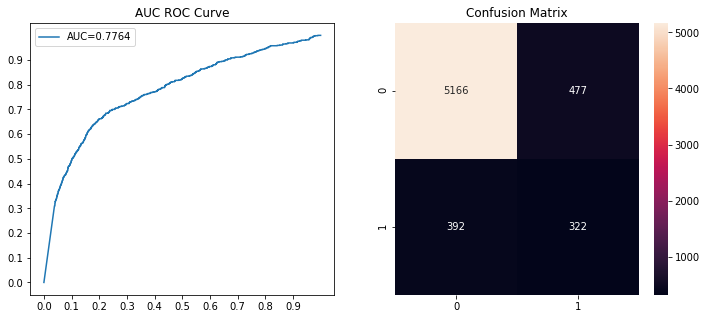


Model Name:  KNeighbors
Sklearn LogLoss: 3.80869


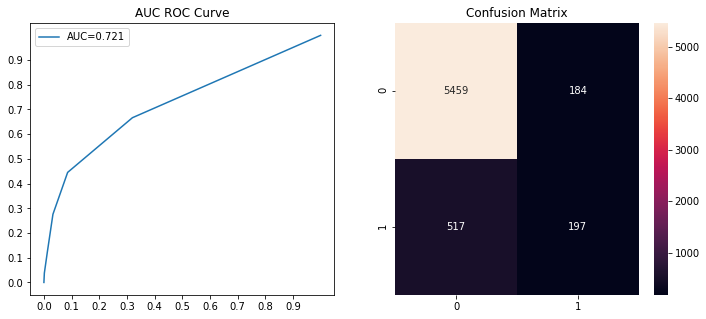


Model Name:  DecisionTreeClassifier
Sklearn LogLoss: 5.82445


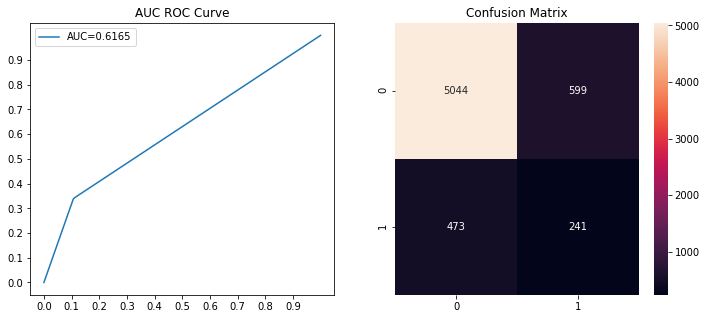


Model Name:  RandomForestClassifier
Sklearn LogLoss: 3.80326


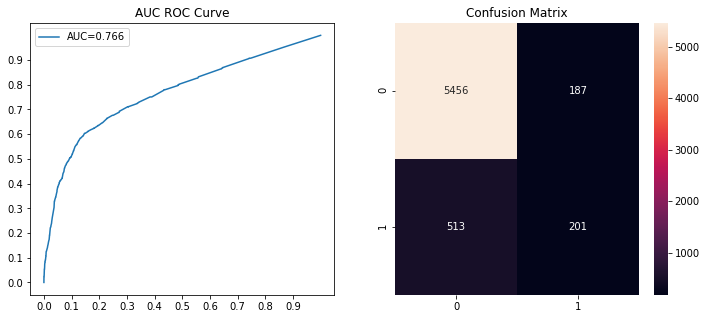


Model Name:  ExtraTreeClassifier
Sklearn LogLoss: 4.25422


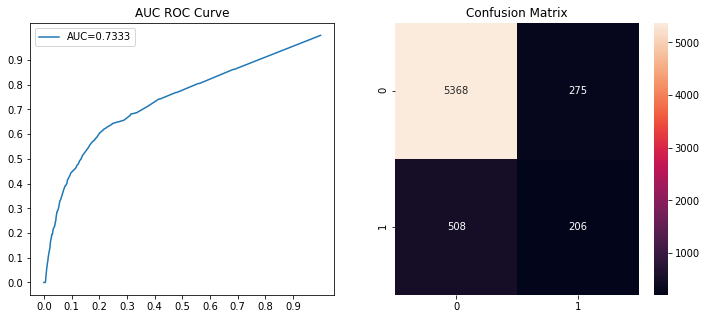


Model Name:  AdaBoostClassifier
Sklearn LogLoss: 3.48268


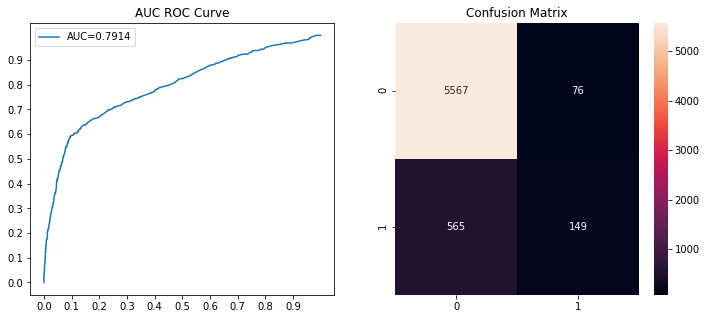


Model Name:  XGBClassifier
[22:52:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:53:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:53:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:53:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

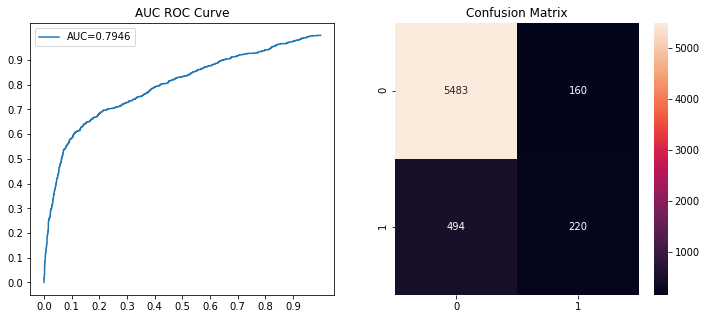

In [95]:
out = run_exps(X_train,y_train,X_test,y_test)

<b>Comparing AUC ROC Curve and Confusion Matrix </b>

In [80]:
chart_data = out.groupby('model').agg('mean').reset_index()

In [84]:
chart_data.sort_values(by = ['test_roc_auc'], ascending = False, inplace = True)
chart_data

,model,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc
0,AdaBoostClassifier,0.770953,0.103678,0.895493,0.877500,0.895493,0.870722,0.790040
5,XGBClassifier,2.159083,0.026008,0.891520,0.871460,0.891520,0.874140,0.772747
6,naive_bayes,0.032153,0.020561,0.856553,0.863592,0.856553,0.859737,0.762045
4,RandomForestClassifier,1.891819,0.200234,0.887311,0.866649,0.887311,0.871464,0.761290
2,ExtraTreeClassifier,2.280179,0.232035,0.875826,0.857713,0.875826,0.864477,0.734275
3,KNeighbors,0.217261,8.437931,0.886289,0.864776,0.886289,0.869733,0.718042
1,DecisionTreeClassifier,0.154970,0.011731,0.827093,0.835312,0.827093,0.831041,0.609043


Text(0, 0.5, 'Algorithm')

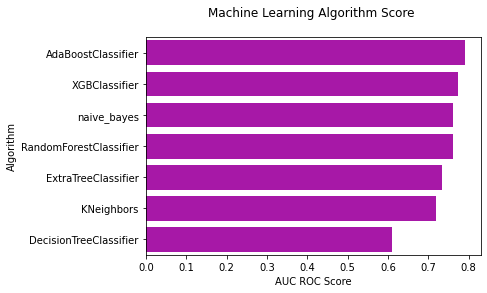

In [85]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='test_roc_auc',y = 'model',data = chart_data, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Score \n')
plt.xlabel('AUC ROC Score')
plt.ylabel('Algorithm')

## Hyper Parameter Tuning

- We would be tuning XG Boost and Ada Boost since this two models has the highest AUC ROC Score

### XG Boost

In [406]:
kfold = StratifiedKFold(n_splits=3)

estimator = XGBClassifier(
    objective= 'binary:logistic',    
    seed=42
)

# Define our search space for grid search
ex_param_grid = [
  {
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [10],
  }
]

# AUC and accuracy as score
scoring = {'AUC':'roc_auc'}
# Define grid search
grid = GridSearchCV(
  estimator=estimator,
  param_grid=gbm_param_grid,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)
# Fit grid search
model = grid.fit(X_train, y_train)

model.best_estimator_

Fitting 3 folds for each of 399 candidates, totalling 1197 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 1197 out of 1197 | elapsed: 31.1min finished


[19:37:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:37:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', clf__learning_rate=0.05,
              clf__max_depth=3, clf__n_estimators=50, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
              tree_method='exact', use_label_encoder=True, ...)

In [416]:
predict = model.predict(X_test)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test, predict)))
print(confusion_matrix(y_test,predict))

Best AUC Score: 0.8006480558174935
Accuracy: 0.8971212836243511
[[5483  160]
 [ 494  220]]


### Ada Boost

In [106]:
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

parameters = {'base_estimator__criterion' : ["gini", "entropy"],
    'base_estimator__max_depth':[i for i in range(2,11,2)],
              'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}

clf = GridSearchCV(abc, parameters,verbose=3,scoring='roc_auc',n_jobs=-1)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 40.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 71.8min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 76.6min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1

In [110]:
predict = clf.predict(X_test)
print('Best AUC Score: {}'.format(clf.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test, predict)))
print(confusion_matrix(y_test,predict))

Best AUC Score: 0.7993706679977448
Accuracy: 0.8997955010224948
[[5571   72]
 [ 565  149]]


## Finalize Model with Hyperparameters Params

In [151]:
kfold = StratifiedKFold(shuffle=True, n_splits=5, random_state=90210)

params = {"clf__max_depth": [3],
 "clf__learning_rate": [0.05],
 "clf__n_estimators": [50] 
}

estimator = XGBClassifier(
    objective= 'binary:logistic',    
    seed=42
)


# AUC and accuracy as score
scoring = {'AUC':'roc_auc'}

# Define grid search
grid = GridSearchCV(
  estimator=estimator,
  param_grid=params,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)
# Fit grid search
final_model = grid.fit(X_train, y_train)

final_model.best_estimator_


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.1s remaining:   16.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished


[22:07:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:07:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', clf__learning_rate=0.05,
              clf__max_depth=3, clf__n_estimators=50, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
              tree_method='exact', use_label_encoder=True, ...)

## Feature Importance

In [184]:
kfold = StratifiedKFold(shuffle=True, n_splits=5, random_state=90210)   
fm = XGBClassifier(objective= 'binary:logistic',seed=42)
cv_results = model_selection.cross_validate(fm, X_train, y_train, cv=kfold, scoring=scoring)
ft = fm.fit(X_train, y_train)
y_pred = clf.predict(X_test)

[22:30:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:30:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:30:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:30:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

<Figure size 1296x1080 with 0 Axes>

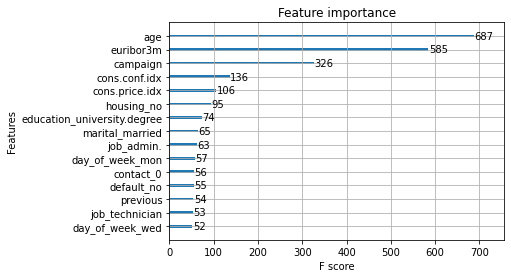

In [195]:
plt.figure(figsize = (18,15))
plot_importance(ft,max_num_features=15)
plt.show()

The Attributes `Age`, `Euribor3m` and `Campaign` plays a makor role in Prediction

## Save Model

In [182]:
ft.save_model('XGBoost_Classifier_Model.model')